<a href="https://colab.research.google.com/github/romenlaw/RL-playground/blob/main/rl_playground2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparation

In [1]:
!pip install git+https://github.com/mimoralea/gym-walk#egg=gym-walk &>/dev/null
!pip install git+https://github.com/mimoralea/gym-bandits#egg=gym-bandits &>/dev/null

In [9]:
import gym, gym_walk, gym_bandits
import numpy as np
from pprint import pprint
from tqdm import tqdm_notebook as tqdm

from itertools import cycle, count
from tabulate import tabulate

import random
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
SEEDS = (12, 34, 56, 78, 90)

%matplotlib inline

In [3]:
import warnings

warnings.filterwarnings('ignore')
# Ignore all DeprecationWarning
# warnings.filterwarnings('ignore', category=DeprecationWarning)
# warnings.filterwarnings('ignore', category=UserWarning)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Utilities

In [22]:
# slightly modified from chapter 4: pi is a function instead of dict
def policy_evaluation(pi, P, gamma=1.0, theta=1e-10):
  prev_V = np.zeros(len(P)) # initialise value for each state to 0
  while True:
    V = np.zeros(len(P))
    for s in range(len(P)):
      # example of P[s]pi[s]: [(0.8, 0, 0.0, True), (0.0, 1, 0.0, False), (0.2, 2, 1.0, True)]
      for (prob, next_state, reward, done) in P[s][pi(s)]:
        # multiply by not done s.t. V(s)=0 if s is terminal state
        V[s] += prob * (reward + gamma * prev_V[next_state] * (not done) )
    # stop the while loop if values have converged
    if np.max(np.abs(prev_V - V)) < theta:
      break

    prev_V = V.copy()
  return V

def print_policy(pi, P, action_symbols=('<', 'v', '>', '^'), n_cols=4, title='Policy:'):
  print(title)
  arrs = {k:v for k,v in enumerate(action_symbols)}
  for s in range(len(P)):
    a = pi(s)
    print("| ", end="")
    if np.all([done for action in P[s].values() for _, _, _, done in action]):
        print("".rjust(9), end=" ")
    else:
        print(str(s).zfill(2), arrs[a].rjust(6), end=" ")
    if (s + 1) % n_cols == 0: print("|")

def print_state_value_function(V, P, n_cols=4, prec=3, title='State-value function:'):
  print(title)
  for s in range(len(P)):
    v = V[s]
    print("| ", end="")
    if np.all([done for action in P[s].values() for _, _, _, done in action]):
        print("".rjust(9), end=" ")
    else:
        print(str(s).zfill(2), '{}'.format(np.round(v, prec)).rjust(6), end=" ")
    if (s + 1) % n_cols == 0: print("|")

def print_action_value_function(Q,
                                optimal_Q=None,
                                action_symbols=('<', '>'),
                                prec=3,
                                title='Action-value function:'):
  vf_types=('',) if optimal_Q is None else ('', '*', 'er')
  headers = ['s',] + [' '.join(i) for i in list(itertools.product(vf_types, action_symbols))]
  print(title)
  states = np.arange(len(Q))[..., np.newaxis]
  arr = np.hstack((states, np.round(Q, prec)))
  if not (optimal_Q is None):
    arr = np.hstack((arr, np.round(optimal_Q, prec), np.round(optimal_Q-Q, prec)))
  print(tabulate(arr, headers, tablefmt="fancy_grid"))

def probability_success(env, pi, goal_state, n_episodes=100, max_steps=200):
  random.seed(123); np.random.seed(123) ; env.seed(123)
  results = []
  for _ in range(n_episodes):
    state, done, steps = env.reset(), False, 0
    while not done and steps < max_steps:
      state, _, done, h = env.step(pi(state))
      steps += 1
    results.append(state == goal_state)
  return np.sum(results)/len(results)*100

def mean_return(env, gamma, pi, n_episodes=100, max_steps=200):
  random.seed(123); np.random.seed(123) ; env.seed(123)
  results = []
  for _ in range(n_episodes):
    state, done, steps = env.reset(), False, 0
    results.append(0.0)
    while not done and steps < max_steps:
      state, reward, done, _ = env.step(pi(state))
      results[-1] += (gamma**steps * reward)
      steps += 1
  return np.mean(results)

In [4]:
"""exponentially decaying schedule
this function allows you to calculate all the values for alpha for the full training process
"""
def decay_schedule(init_value, min_value,
                   decay_ratio, # determines how many episodes to use for decay
                   max_steps, # i.e. n_episodes in previous chapters
                   log_start=-2, log_base=10):
  assert min_value<=init_value, "min_value must be <= init_value"
  decay_steps = max(int(max_steps*decay_ratio), 1)
  rem_steps = max_steps - decay_steps # remaining steps (i.e. not used for decay)

  # calculate actual values of an inverse log curve ([::-1] reverse the order)
  values = np.logspace(start=log_start, stop=0,
                       num=decay_steps, # number of samples to generate
                       base=log_base,
                       endpoint=True # samples are inclusive of 'stop'
                       )[::-1]
  # print("reverse logspace: ", values)
  # normalise to between 0 and 1
  values = (values - values.min()) / (values.max() - values.min())
  # transform the points to lay between init_value and min_value
  values = min_value + (init_value - min_value) * values
  values = np.pad(values, (0, rem_steps), 'edge')
  return values


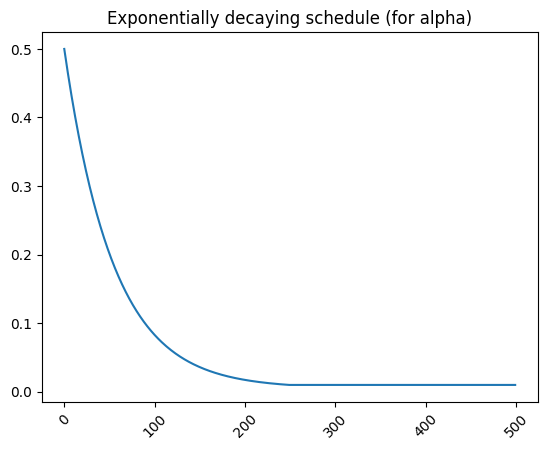

In [5]:
plt.plot(decay_schedule(0.5, 0.01, 0.5, 500))
plt.title('Exponentially decaying schedule (for alpha)')
plt.xticks(rotation=45)
plt.show()

In [6]:
"""Generate full trajectory
Running a policy and extracting the collection of experience tuples
(the trajectories) for offline processing.
"""
def generate_trajectory(pi, env, max_steps=200):
  done, trajectory =  False, []
  while not done:
    state = env.reset()
    trajectory = []
    t = 0
    while t<max_steps and not done: # max_steps allows truncation of long trajectory
      action = pi(state)
      next_state, reward, done, _ = env.step(action)
      experience = (state, action, reward, next_state, done)
      trajectory.append(experience)
      state = next_state

  return np.array(trajectory, np.object_)

## Plotting functions

In [26]:
def plot_value_function(title, V_track, V_true=None, log=False, limit_value=0.05, limit_items=5):
    np.random.seed(123)
    per_col = 25
    linecycler = cycle(["-","--",":","-."])
    legends = []

    valid_values = np.argwhere(V_track[-1] > limit_value).squeeze()
    items_idxs = np.random.choice(valid_values,
                                  min(len(valid_values), limit_items),
                                  replace=False)
    # draw the true values first
    if V_true is not None:
        for i, state in enumerate(V_track.T):
            if i not in items_idxs:
                continue
            if state[-1] < limit_value:
                continue

            label = 'v({})'.format(i)
            plt.axhline(y=V_true[i], color='k', linestyle='-', linewidth=1)
            plt.text(int(len(V_track)*1.02), V_true[i]+.01, label)

    # then the estimates
    for i, state in enumerate(V_track.T):
        if i not in items_idxs:
            continue
        if state[-1] < limit_value:
            continue
        line_type = next(linecycler)
        label = 'V({})'.format(i)
        p, = plt.plot(state, line_type, label=label, linewidth=3)
        legends.append(p)

    legends.reverse()

    ls = []
    for loc, idx in enumerate(range(0, len(legends), per_col)):
        subset = legends[idx:idx+per_col]
        l = plt.legend(subset, [p.get_label() for p in subset],
                       loc='center right', bbox_to_anchor=(1.25, 0.5))
        ls.append(l)
    [plt.gca().add_artist(l) for l in ls[:-1]]
    if log: plt.xscale('log')
    plt.title(title)
    plt.ylabel('State-value function')
    plt.xlabel('Episodes (log scale)' if log else 'Episodes')
    plt.show()

In [25]:
def plot_targets(targets, init_state, title):
    x = range(len(targets[init_state]))
    y = targets[init_state]

    label = 'v({})'.format(init_state)
    plt.axhline(y=V_true[init_state], color='k', linestyle='-', linewidth=1)
    plt.text(int(x[-1]*1.02), V_true[init_state]+.01, label)

    plt.scatter(x, y,
                c=np.array(targets[init_state]),
                cmap=plt.get_cmap('viridis'),
                alpha=0.4)
    plt.title(title)

    plt.ylabel('Target value')
    plt.xlabel('Estimate sequence number')
    plt.show()

## Random Walk Environment
Apply the Random Walk environment, using a policy of 'always left'.
```
 _________________________________
| H 0 | 1 | 2 | S 3 | 4 | 5 | G 6 |
 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
```
There are 7 states in this env, H=hole, G=Goal, S=Start

In [23]:
env = gym.make('RandomWalk-v0')
init_state = env.reset()
goal_state = 6
gamma = 1.0
n_episodes = 500
P = env.env.P

LEFT, RIGHT = range(2)
# always left policy:
pi = lambda s: {
    0:LEFT, 1:LEFT, 2:LEFT, 3:LEFT, 4:LEFT, 5:LEFT, 6:LEFT
}[s]
V_true = policy_evaluation(pi, P, gamma=gamma)

print_state_value_function(V_true, P, n_cols=7)
print()
print_policy(pi, P, action_symbols=('<', '>'), n_cols=7)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}.'.format(
    probability_success(env, pi, goal_state=goal_state),
    mean_return(env, gamma, pi)))


State-value function:
|           | 01  0.167 | 02  0.333 | 03    0.5 | 04  0.667 | 05  0.833 |           |

Policy:
|           | 01      < | 02      < | 03      < | 04      < | 05      < |           |
Reaches goal 44.00%. Obtains an average return of 0.4400.


In [21]:
pi

<function __main__.<lambda>(s)>

In [16]:
env.spec

EnvSpec(id='RandomWalk-v0', entry_point='gym_walk.envs:WalkEnv', reward_threshold=1.0, nondeterministic=True, max_episode_steps=100, order_enforce=True, autoreset=False, disable_env_checker=False, new_step_api=False, kwargs={'n_states': 5, 'p_stay': 0.0, 'p_backward': 0.5}, namespace=None, name='RandomWalk', version=0)

In [20]:
P

{0: {0: [(0.5, 0, 0.0, True), (0.0, 0, 0.0, True), (0.5, 0, 0.0, True)],
  1: [(0.5, 0, 0.0, True), (0.0, 0, 0.0, True), (0.5, 0, 0.0, True)]},
 1: {0: [(0.5, 0, 0.0, True), (0.0, 1, 0.0, False), (0.5, 2, 0.0, False)],
  1: [(0.5, 2, 0.0, False), (0.0, 1, 0.0, False), (0.5, 0, 0.0, True)]},
 2: {0: [(0.5, 1, 0.0, False), (0.0, 2, 0.0, False), (0.5, 3, 0.0, False)],
  1: [(0.5, 3, 0.0, False), (0.0, 2, 0.0, False), (0.5, 1, 0.0, False)]},
 3: {0: [(0.5, 2, 0.0, False), (0.0, 3, 0.0, False), (0.5, 4, 0.0, False)],
  1: [(0.5, 4, 0.0, False), (0.0, 3, 0.0, False), (0.5, 2, 0.0, False)]},
 4: {0: [(0.5, 3, 0.0, False), (0.0, 4, 0.0, False), (0.5, 5, 0.0, False)],
  1: [(0.5, 5, 0.0, False), (0.0, 4, 0.0, False), (0.5, 3, 0.0, False)]},
 5: {0: [(0.5, 4, 0.0, False), (0.0, 5, 0.0, False), (0.5, 6, 1.0, True)],
  1: [(0.5, 6, 1.0, True), (0.0, 5, 0.0, False), (0.5, 4, 0.0, False)]},
 6: {0: [(0.5, 6, 0.0, True), (0.0, 6, 0.0, True), (0.5, 6, 0.0, True)],
  1: [(0.5, 6, 0.0, True), (0.0, 6, 0

# Evaluating Agent's Behaviour

**Prediction Problem** - estimate the value of policies, without MDP, because it depends on future.




## First-Visit Monte-Carlo (FV MC)

**Monte-Carlo prediction** (MC) - run several episodes with the policy collecting hundreds of trajectories (i.e. taking actions from time step t till end of episode (at time step T), using $t:T$ as the notation below), and then calculate average for every state.

Monte-Carlo learning:
Action-value function is the expectation of returns.
$$v_\pi(S) = \mathbb E_\pi[G_{t:T}|S_t=s]$$
and Returns are total discounted rewards.
$$G_{t:T}=R_{t+1}+\gamma R_{t+2}+ \gamma R_{t+3} +... + \gamma^{T-1}R_T$$

So in MC, the first thing we do is sample the policy for a trajectory (i.e. from timestep t to T):
$$S_t,A_t,R_{t+1},S_{t+1},...,R_T,S_T \sim \pi_{t:T}$$
Then add up the per-state returns:
$$T_T(S_t)=T_T(S_t)+G_{t:T}$$
and increment a counter N:
$$N_T(S_T)=N_T(S_t)+1$$

We can estimate the expectation using empirical mean. So the estimated action-value function for a state is just the mean return for that state:
$$V_T(S_t)=\dfrac{T_T(S_t)}{N_T(S_t)}$$

As the count approach infinity, the estimate will approach the true value:
$$N(s) \to \infty , V(s) \to v_\pi(s)$$

Rewrite the above using recursion, so that we don't have to calculate sum of returns for all states (more efficient):
$$V_T(S_t)=V_{T-1}(S_t)+\dfrac{1}{N_T(S_t)}\left[G_{t:T}- V_{T-1}S(t)\right] $$
Replace the mean for a learning value that can be time dependent, or constant:
$$V_T(S_t)=V_{T-1}(S_t)+\alpha_t\left[\overbrace{\underbrace{G_{t:T}}_{\text { MC} \\ \text {target}}- V_{T-1}S(t)}^{\text {MC error}}\right] $$
Note that V is only calculated at the end of an episode, timestep T, because G depends on it.



## Every-Visit Monte-Carlo (EV MC)

One trajectory can visit a state multiple times. In FV MC we only calculate the return at the first visit of a state; for EV MC, we do this for every visit of the state.

IID = independent and identically distributed.

In FVMC, each trajectory is IID, so as we collect infinite samples, the estimate will converge to true value.

But in EVMC, trajectories are not IID. But EVMC has also been proven to converge to true value given infiniate samples.

In [38]:
"""Monte-Carlo Prediction
the function works for FVMC and EVMC
"""
def mc_prediction(pi, env,
                  gamma=1.0, # reward discount factor
                  init_alpha=0.5,
                  min_alpha=0.01,
                  alpha_decay_ratio=0.3, # use 30% of n_episodes to decay alpha
                  n_episodes=500,
                  max_steps=100, # stop trajectory if it gets too long
                  first_visit=True # flag for FVMC or EVMC
                  ):
  nS = env.observation_space.n # number of states
  # generates all discounts (gamma) at once, e.g. for gamma=0.99, it gives
  # 1, 0.99, 0.99**2, 0.99**3, etc. same as: [gamma**i for i in range(max_steps)]
  discounts = np.logspace(0, max_steps, num=max_steps, base=gamma, endpoint=False)
  alphas = decay_schedule(init_alpha, min_alpha, alpha_decay_ratio, n_episodes)

  V = np.zeros(nS)
  # per episode copy of V for offline analysis
  V_track = np.zeros((n_episodes, nS))
  targets = {state:[] for state in range(nS)}

  for e in tqdm(range(n_episodes), leave=False):
    trajectory = generate_trajectory(pi, env, max_steps)
    visited = np.zeros(nS, dtype=np.bool_)
    for t, (state, _, reward, _, _) in enumerate(trajectory):
      if visited[state] and first_visit:
        continue
      # if this is first visit, or doing EVMC, then process current state.
      visited[state] = True
      n_steps = len(trajectory[t:]) # number of steps from t:T
      # calculate Return.
      G = np.sum(discounts[:n_steps] * trajectory[t:, 2]) # 2nd in the tuple is reward
      V[state] = V[state] + alphas[e] * (G - V[state]) # estimate value function

      targets[state].append(G)

    V_track[e] = V

  return V.copy(), V_track, targets

In [8]:
np.logspace(0, 10, 10, base=0.99, endpoint=False), [0.99**i for i in range(10)]

(array([1.        , 0.99      , 0.9801    , 0.970299  , 0.96059601,
        0.95099005, 0.94148015, 0.93206535, 0.92274469, 0.91351725]),
 [1.0,
  0.99,
  0.9801,
  0.970299,
  0.96059601,
  0.9509900498999999,
  0.941480149401,
  0.9320653479069899,
  0.9227446944279201,
  0.9135172474836408])

  0%|          | 0/500 [00:00<?, ?it/s]

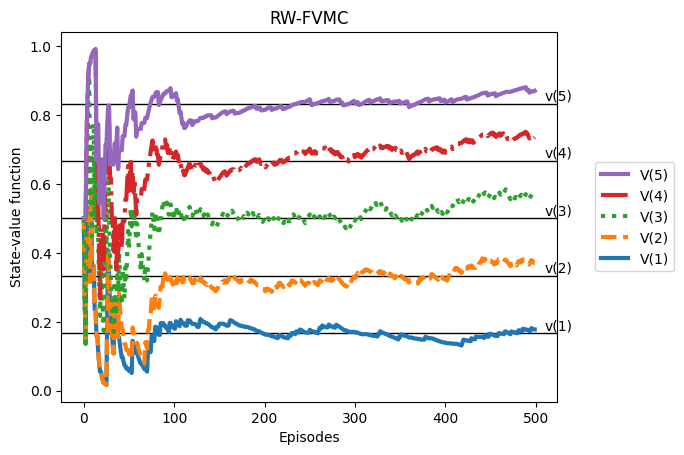

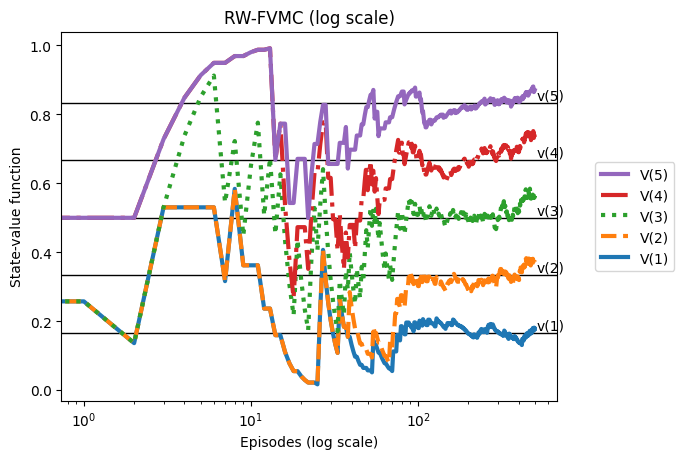

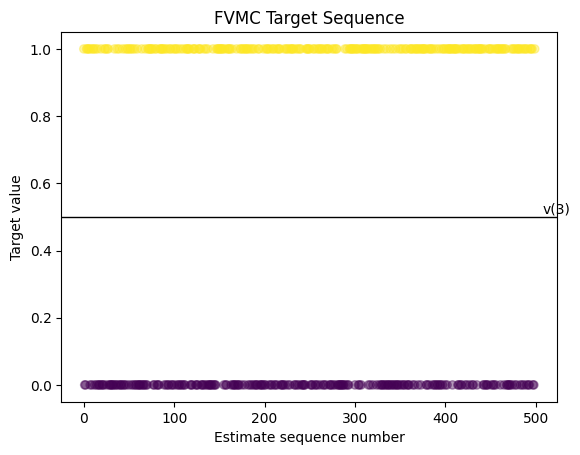

In [49]:
# testing it on random walk
env = gym.make('RandomWalk-v0')
V, V_track, targets = mc_prediction(pi, env)
plot_value_function("RW-FVMC", V_track, V_true)
plot_value_function("RW-FVMC (log scale)", V_track, V_true, log=True)
plot_targets(targets, init_state, 'FVMC Target Sequence')

  0%|          | 0/500 [00:00<?, ?it/s]

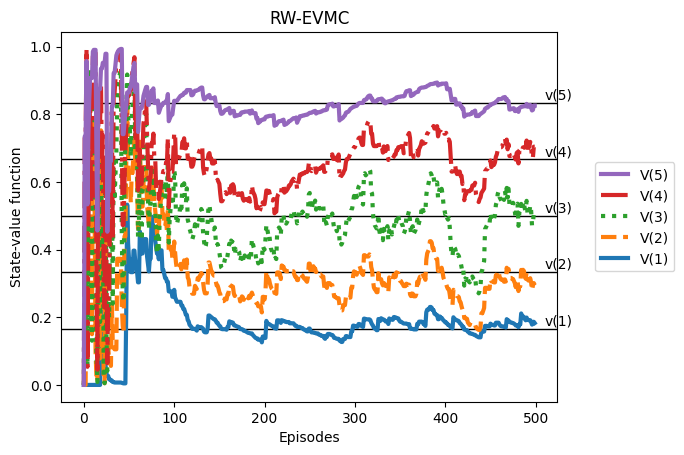

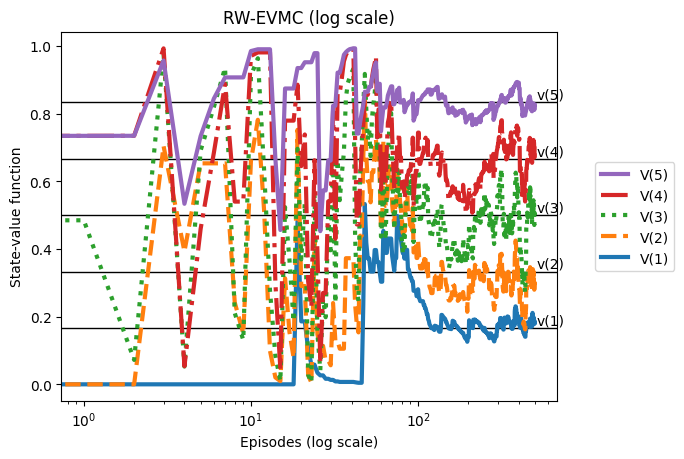

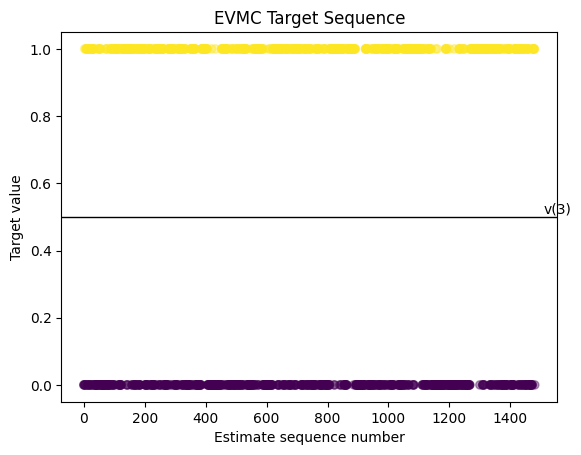

In [50]:
env = gym.make('RandomWalk-v0')
V, V_track, targets = mc_prediction(pi, env, first_visit=False)
plot_value_function("RW-EVMC", V_track, V_true)
plot_value_function("RW-EVMC (log scale)", V_track, V_true, log=True)
plot_targets(targets, init_state, 'EVMC Target Sequence')

The above plots show that
* MC is high variance - they jumpy around the true values. This is more so on EVMC.
* MC is unbiased - the target plots show either 1 or 0, i.e. the return at terminal states

## Temporal Difference learning (TD)

MC has to wait till end of episode to get the actual return $G_{t:T}$ to update state-value function estimate $V_T(S_t)$; it's good at convergence, *unbiased estimate*, but has *high variance* due to randomn events in trajectory.

TD is not MC because it can learn from imcomplete episode by using *one-step actual return* which is just the immediate reward $R_{t+1}$, then an *estimate of the return from next state onward* (t+1:T), i.e. $V(S_{t+1})$. That is,  $R_{t+1} + \gamma V(S_{t+1})$, which is called **TD Target**.

TD estimates $v_\pi (s)$ using an estimate of it, i.e. it 'bootstraps' - making estimate using an estimate, hence, a *biased estimation*. It also has much lower variance than MC because TD Target only depends on a single transition, a single reward, so there is much less randomness being accumulcatd. So TD learns much faster than MC.

TD learning equations:

We start from the definition of state-value function:
$$v_\pi(s)=\mathbb E[G_{t:T}|S_t=s]$$
From the definition of Return, we can re-arrange it into recursive form:
$$\begin{align}
G_{t:T}&=R_{t+1}+\gamma R_{t+2} + \gamma^2 R_{t+3} + ... + \gamma^{T-1} R_T \\
&= R_{t+1} + \gamma (R_{t+2} + \gamma R_{t+3} + ... + \gamma^{T-2}R_T) \\
&= R_{t+1} + \gamma G_{t+1:T}
\end{align}$$

We can use the same recursive definition to rewrite state-value function (because the Expectation of the Returns from the next state is simply the state-value function of the next state):
$$\begin{align}
v_\pi(s) &= \mathbb E[G_{t:T}|S_t=s] \\
&= \mathbb E[R_{t+1}+\gamma G_{t+1:T} | S_t=s] \\
&= \mathbb E[R_{t+1}+\gamma v_\pi(S_{t+1}) | S_t=s]
\end{align}$$

This means we can estimate the state-value function on every time step. We roll out a single interaction step:
$S_t, A_t, R_{t+1}, S_{t+2} \sim \pi_{t:t+1}$ and can obtain an estimation V(S) of true state-value function $v_\pi(S)$ a different way than MC:
$$V_{t+1}(S_t)=V_t(S_t)+\alpha_t\left[\overbrace{\underbrace{R_{t+1}+\gamma V_t(S_{t+1})}_{\text {TD target}}-V_t(S_t)}^{\text {TD error}}\right]$$
The key difference is we are now estimating $v_\pi(S_t)$ with an *estimate* of $v_\pi(S_{t+1})$.

In [43]:
def td(pi, env,
       gamma=1.0,
       init_alpha=0.5, min_alpha=0.01,
       alpha_decay_ratio=0.3, # use 30% of n_episodes to decay alpha
       n_episodes=500):
  nS = env.observation_space.n # number of states
  # initialise state-value function to zeros
  V = np.zeros(nS)
  V_track = np.zeros((n_episodes, nS))
  targets = {state:[] for state in range(nS)}
  alphas = decay_schedule(init_alpha, min_alpha,
                          alpha_decay_ratio, n_episodes)
  for e in tqdm(range(n_episodes), leave=False):
    state = env.reset()
    done = False
    while not done:
      # sameple the policy for the action to take in state 'state'
      action = pi(state)
      # use the action to interact with env... roll out the policy one-step
      next_state, reward, done, _ = env.step(action)

      # we can immediately estimate V
      td_target = reward + gamma * V[next_state] * (not done)
      td_error = td_target - V[state]
      V[state] = V[state] + alphas[e] * td_error

      targets[state].append(td_target)

      # don't forget to update state for next iteration
      state = next_state
    V_track[e] = V

  return V, V_track, targets

  0%|          | 0/500 [00:00<?, ?it/s]

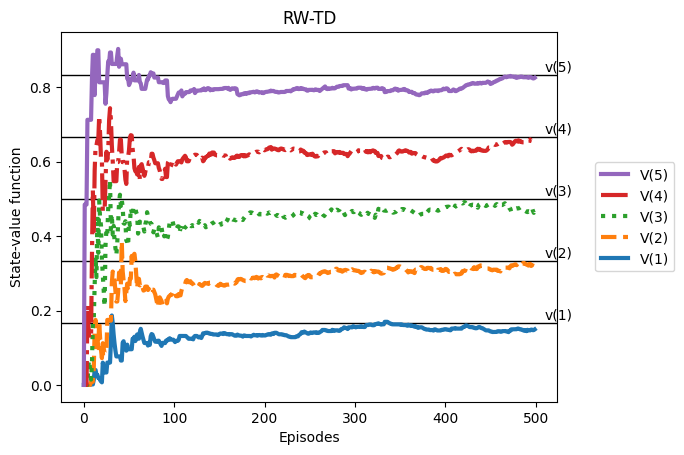

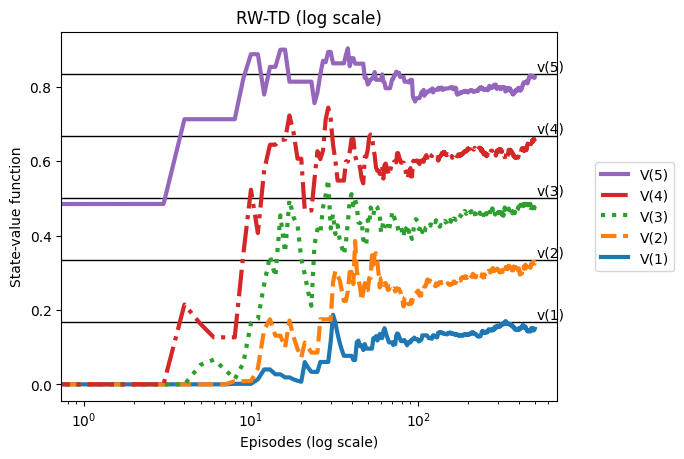

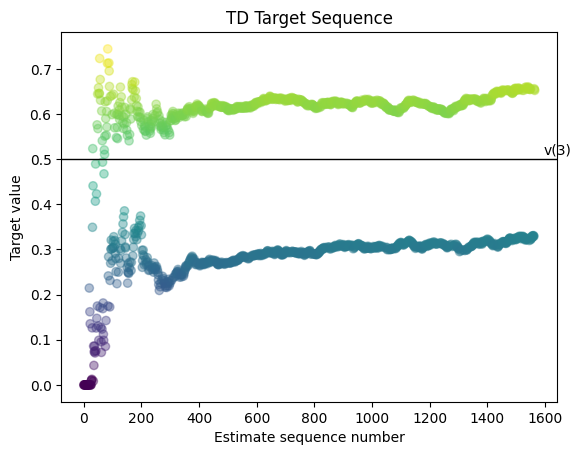

In [51]:
env = gym.make('RandomWalk-v0')
V, V_track, targets = td(pi, env)
plot_value_function("RW-TD", V_track, V_true)
plot_value_function("RW-TD (log scale)", V_track, V_true, log=True)
plot_targets(targets, init_state, 'TD Target Sequence')

From the above plots:
* TD state-value function plot shows less variance around the true values, comparing to MC. This shows TD is low variance
* TD Target plot jumps between approx 0.7 and 0.3 (instead of 1 and 0 at terminal states) because TD only estimate on next state. This shows TD is biased.
